In [3]:
cd dataset

C:\Users\Miya\Desktop\cna\dataset


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('repositories_refined.csv',parse_dates=['Month, Day, Year of Date'])
#data = data[data['Coding Effort']!=0]
data.columns= ['Worker ID','Repository ID','Coding Effort','Month, Day, Year of Date']

In [6]:
data.head()

Worker ID Repository ID  Coding Effort Month, Day, Year of Date
0       aaa           AAA           0.00               2015-07-01
1       dxw           HEL           5.00               2015-07-01
2       woe           WHS           4.73               2015-07-01
3       woe           EZR           0.26               2015-07-01
4       wlk           RJA           5.00               2015-07-01

In [ ]:
# Normalize

#data['Coding Effort'] = data.groupby(['Worker ID']).transform(lambda x: (x - x.mean()))

In [23]:
np.min(data.groupby(['Worker ID']).transform(lambda x: x - x.mean()).values)

-4.9227941176470589

(array([  1994.,   8835.,  18598.,  27198.,  43799.,  24952.,  24163.,
         15303.,   6458.,   1054.]),
 array([  0.07720588,   1.09834893,   2.11949198,   3.14063503,
          4.16177807,   5.18292112,   6.20406417,   7.22520722,
          8.24635027,   9.26749332,  10.28863636]),
 <a list of 10 Patch objects>)

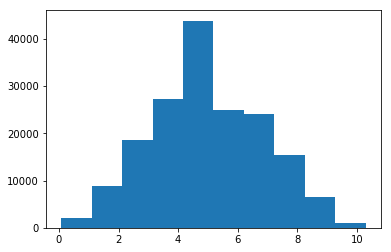

In [24]:
plt.hist(data.groupby(['Worker ID']).transform(lambda x: x - x.mean()+5).values)

In [25]:
data['Coding Effort'] = data.groupby(['Worker ID']).transform(lambda x: x - x.mean()+5).values

In [26]:
X_test = data[data['Month, Day, Year of Date']>='2015-07-08']
X_train = data[data['Month, Day, Year of Date']<'2015-07-08']

In [27]:
data[data['Month, Day, Year of Date']<'2015-07-08'].head()

Worker ID Repository ID  Coding Effort Month, Day, Year of Date
0       aaa           AAA       5.000000               2015-07-01
1       dxw           HEL       5.002424               2015-07-01
2       woe           WHS       7.512658               2015-07-01
3       woe           EZR       3.042658               2015-07-01
4       wlk           RJA       5.279545               2015-07-01

In [432]:
def dirty_model():
    pred_base = []
    tp = data[data['Month, Day, Year of Date']<'2015-07-08'].groupby(['Worker ID','Repository ID']).sum().reset_index()
    for deve in to_predict_deve:
        old = tp[tp['Worker ID']==deve]['Repository ID']
        new = [i for i in Most_popu_repo if i not in old]
    pred_base.append(new)
    
    return pred_base

In [28]:
Most_popu_repo = data[data['Month, Day, Year of Date']<'2015-07-08'].groupby('Repository ID').count().sort_values('Worker ID',ascending = False).index

In [29]:
print(X_train.shape)
print(X_test.shape)

(13155, 4)
(159199, 4)


In [30]:
deve_nodes_train = list(set(X_train.values[:,0]))
deve_nodes_test = list(set(X_test.values[:,0]))

In [31]:
X_test = X_test[X_test['Worker ID'].isin([test for test in deve_nodes_test if test in deve_nodes_train])]

In [32]:
X_test = X_test.groupby(['Worker ID','Repository ID']).sum().reset_index()

In [33]:
t1 = pd.DataFrame(X_train['Worker ID']+X_train['Repository ID'],columns = ['temp'])
t2 = pd.DataFrame(X_test['Worker ID']+X_test['Repository ID'],columns = ['temp'])

In [34]:
X_test = X_test[~t2['temp'].isin(t1['temp'])]

In [35]:
sum(pd.DataFrame(X_test["Worker ID"]+X_test["Repository ID"])[0].isin(t1['temp']))

0

In [36]:
X_test.shape

(2775, 3)

In [37]:
len(list(set(X_test.values[:,0])))

945

In [38]:
len(list(set(X_train.values[:,0])))

2321

In [39]:
X_train = X_train.groupby(['Worker ID','Repository ID']).sum().reset_index().values

In [40]:
X_test.shape[0]/X_train.shape[0]

0.8748423707440101

In [113]:
np.max(X_test.groupby('Worker ID').count().values[:,0])

33

In [119]:
len(set(list(X_train[:,1])))

921

In [41]:
actual_list = []
to_predict_deve = set(X_test['Worker ID'])
print(len(to_predict_deve))
for dev in to_predict_deve:
    repo = X_test[X_test['Worker ID']==dev]['Repository ID'].values
    actual_list.append(list(repo))

945


In [42]:
import networkx as nx
%matplotlib inline
from networkx.algorithms import bipartite
G_train = nx.Graph()
for i,v,j in zip(X_train[:,0],X_train[:,1],X_train[:,2]):
    G_train.add_edge(i,v,weight = j)

In [43]:
nx.write_gml(G_train,'g_2.gml')

In [45]:
X_train.shape

(3172, 3)

In [46]:
X_test.shape

(2775, 3)

In [44]:
deve_nodes = list(set(X_train[:,0]))

In [51]:
def normalize(x):
    if x==0:
        x = 1
    else:
        x
    return x

def my_weight(G_train, u, v, weight='weight'):
    w = 0
    for nbr in set(G_train[u]) & set(G_train[v]):
        u_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[u].values()))))
        v_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[v].values()))))
        nbr_sum = normalize(sum(list(map(lambda x:x['weight'],G_train[nbr].values()))))
        
        trans = (G_train.edge[u][nbr].get(weight,1)/u_sum) * (G_train.edge[v][nbr].get(weight,1)/nbr_sum)        
        w += np.sqrt(trans)
        return w 
    
    
def jaccard(G, u, v):
    unbrs = set(G[u])
    vnbrs = set(G[v])
    return float(len(unbrs & vnbrs)) / len(unbrs)

In [54]:
def project_graph(G_train,method = 'binary'):
    
    if method =='binary':
        graph = nx.projected_graph(G_train,deve_nodes)
    if method == 'my_weight':
        graph = bipartite.generic_weighted_projected_graph(G_train, deve_nodes, weight_function= my_weight)
        graph = nx.Graph(graph) 
    if method == 'jaccard':
        graph = bipartite.generic_weighted_projected_graph(G_train, deve_nodes, weight_function= jaccard)
        graph = nx.Graph(graph) 

    return graph

for m in ['binary','my_weight','jaccard']:
    graph = project_graph(G_train,method = m)
    nx.write_gml(graph,m+'.gml')

In [55]:
import itertools
def neighbors_cluster(node, method = 'binary' ):
    
    refer = pd.read_csv(method+'.csv').set_index('nodes')    
    ml = refer.ix[node,0]
    info = refer.ix[node,1]
    wt = refer.ix[node,2]
    fg = refer.ix[node,3]
    lp = refer.ix[node,4]
    #kmeans = refer.ix[node,5]
    spherical = refer.ix[node,5]
    tied = refer.ix[node,6]
    diag = refer.ix[node,7]
    full = refer.ix[node,8]
    
    ml_nn = refer[refer['ml_member']==ml].index
    wt_nn = refer[refer['wt_member']==wt].index
    info_nn = refer[refer['info_member']==info].index
    fg_nn = refer[refer['fg_member']==fg].index
    lp_nn = refer[refer['lp_member']==lp].index
    #kmeans_nn = refer[refer['kmeans']==kmeans].index
    spherical_nn = refer[refer['gmmspherical']==spherical].index
    tied_nn = refer[refer['gmmtied']==tied].index
    diag_nn = refer[refer['gmmdiag']==diag].index
    full_nn = refer[refer['gmmfull']==full].index
    
    cluster_nn = list(itertools.chain(wt_nn,ml_nn,info_nn,fg_nn,lp_nn,spherical_nn,tied_nn,diag_nn,full_nn)) #ml_nn,info_nn
    
    return cluster_nn

In [56]:
def neighbors_cluster_weighted(node, method = 'binary'):
    
    refer = pd.read_csv(method+'.csv').set_index('nodes') 
    
    ml = refer.ix[node,0]
    info = refer.ix[node,1]
    wt = refer.ix[node,2]
    fg = refer.ix[node,3]
    lp = refer.ix[node,4]
    #kmeans = refer.ix[node,5]
    spherical = refer.ix[node,5]
    tied = refer.ix[node,6]
    diag = refer.ix[node,7]
    full = refer.ix[node,8]
    
    ml_nn = refer[refer['ml_member']==ml].index
    wt_nn = refer[refer['wt_member']==wt].index
    info_nn = refer[refer['info_member']==info].index
    fg_nn = refer[refer['fg_member']==fg].index
    lp_nn = refer[refer['lp_member']==lp].index
    #kmeans_nn = refer[refer['kmeans']==kmeans].index
    spherical_nn = refer[refer['gmmspherical']==spherical].index
    tied_nn = refer[refer['gmmtied']==tied].index
    diag_nn = refer[refer['gmmdiag']==diag].index
    full_nn = refer[refer['gmmfull']==full].index
    

    
    return wt_nn,ml_nn,info_nn,fg_nn,lp_nn,spherical_nn,tied_nn,diag_nn,full_nn

In [57]:
K = 100
def limit_k(rs_list, k = K):
    if len(rs_list)<k:
        return rs_list
    else:
        return rs_list[:k]  

In [59]:
def ensemble_similarity(node,wf):
    
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    cluster_nn = neighbors_cluster(node,method = 'binary')
    
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*we

        
    for nn in cluster_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*1
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [60]:
def community_weight(method = 'binary'):
    
    df = pd.read_csv(method +'.csv').set_index('nodes')
    wt_w = len(df['wt_member'].unique())/100
    ml_w = len(df['ml_member'].unique())/100
    info_w = len(df['info_member'].unique())/100
    fg_w = len(df['fg_member'].unique())/100
    lp_w = len(df['lp_member'].unique())/100
    
    wt_w =  np.sqrt((wt_w))
    ml_w =  np.sqrt((ml_w))
    info_w = np.sqrt(info_w)
    fg_w = np.sqrt(fg_w)
    lp_w = np.sqrt(lp_w)
    
    return wt_w,ml_w,info_w,fg_w,lp_w

In [62]:
def cluster_weight():
    
    spherical = gmm_clusters['spherical']/100
    full = gmm_clusters['full']/100
    diag = gmm_clusters['diag']/100
    tied = gmm_clusters['tied']/100
    
    spherical =  np.sqrt(spherical)
    full =  np.sqrt(full)
    diag = np.sqrt(diag)
    tied = np.sqrt(tied)    

    
    return spherical,full, diag, tied

In [63]:
def ensemble_similarity_weighted(node,wf,method = 'binary'):
    
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    
    wt_nn,ml_nn,info_nn,fg_nn,lp_nn,spherical_nn,tied_nn,diag_nn,full_nn = neighbors_cluster_weighted(node, method = 'binary')
    
    wt_w,ml_w,info_w,fg_w,lp_w = community_weight()
    
    spherical,full, diag, tied = cluster_weight()
     
    dict_rs = dict()
    
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*we
        
    for nn in wt_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*wt_w

    for nn in ml_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*ml_w

    for nn in info_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*info_w
                     
    for nn in fg_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*fg_w
            
    for nn in lp_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*lp_w
            
    for nn in spherical_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*spherical
    for nn in tied_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*tied
    for nn in diag_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*diag
    for nn in full_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*full
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [64]:
def projection_similarity(node,wf):
    nns = bipartite.generic_weighted_projected_graph(G_train, [node], weight_function= wf).edges(data=True)
    
    dict_rs = dict()
        
    for nn_sug in nns:
        nn = nn_sug[1]
        we = nn_sug[2]['weight']
        
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*we
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [65]:
def cluster_similarity(node):
    
    dict_rs = dict()
    cluster_nn = neighbors_cluster(node, method = 'binary')

    for nn in cluster_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [67]:
def cluster_similarity_weighted(node):
    
    dict_rs = dict()
    
    wt_nn,ml_nn,info_nn,fg_nn,lp_nn,spherical_nn,tied_nn,diag_nn,full_nn = neighbors_cluster_weighted(node, method = 'binary')
    
    wt_w,ml_w,info_w,fg_w,lp_w = community_weight()
    spherical,full, diag, tied = cluster_weight()


    for nn in wt_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*wt_w

    for nn in ml_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*ml_w

    for nn in info_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*info_w
            
    for nn in fg_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*fg_w
            
    for nn in lp_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*lp_w

    for nn in spherical_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*spherical
    for nn in tied_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*tied
    for nn in diag_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = (repo_sug[1]['weight'])
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*diag
    for nn in full_nn:
        for repo_sug in G_train[nn].items():
            repo = repo_sug[0]
            ce = repo_sug[1]['weight']
            dict_rs[repo] = dict_rs.get(repo,0.0) + ce*full
        
        
    rs_list = sorted(dict_rs.items(),key = lambda x:x[1],reverse = True)
    
    rs_list = limit_k(rs_list)
    
    rs_list = list(map(lambda x: x[0],rs_list))
    
    return rs_list

In [68]:
def accuracy(actual, predicted, k= K):
    if len(predicted)>k:
        predicted = predicted[:k]
    
    eva = [p for p in predicted if p in actual]
    
    if len(eva)!=0:
        score  = 1
    else:
        score = 0 

    return score 

def accuracy_mean(actual_list, predicted_list, k= 20):

    return np.mean([accuracy(a,p,k) for a,p in zip(actual_list, predicted_list)])
    

In [69]:
def apk(actual, predicted, k= K):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual_list, predicted_list, k= 20):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
            
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual_list, predicted_list)])

In [70]:
def similarity_rs(node_list, choice = "projection_similarity",wf = my_weight):
    
    tp = data[data['Month, Day, Year of Date']<'2015-07-08'].groupby(['Worker ID','Repository ID']).sum().reset_index()
    
    dict_rs = dict()
    
    for node in node_list:
        if choice == 'projection_similarity':
             rs_list = projection_similarity(node,wf)
        if choice == 'cluster_similarity':
             rs_list = cluster_similarity(node)
        if choice == 'cluster_similarity_weighted':
             rs_list = cluster_similarity_weighted(node)
        if choice == 'ensemble_similarity_weighted':
             rs_list = ensemble_similarity_weighted(node,wf)
        if choice == 'ensemble_similarity':
             rs_list = ensemble_similarity(node,wf)
        if choice == 'ensemble_similarity_weighted_half':
            rs_list=[]
            rs_list1 = cluster_similarity_weighted(node)
            rs_list2 = projection_similarity(node,wf)
            for p, sw in zip(rs_list2, rs_list1):
                rs_list.append(p)
                rs_list.append(sw)
            rs_list = limit_k(list(set(rs_list)),k=100)
            
            
        old = tp[tp['Worker ID']==node]['Repository ID']
        rs_list = [i for i in rs_list if i not in old]
            
    
        dict_rs[node] = rs_list
    
    return dict_rs

**Base Model:** binary projection + cluster + community detection

** Models:** 
* my_weight projection 
* jaccard projection
* my_weight projection + cluster 
* jaccard projection + cluster 
* my_weight projection + cluster weighted 
* jaccard projection + cluster weighted


In [71]:
top_K = 10

# baseline model

In [85]:
method = 'binary'

y_predict_dict_c = similarity_rs(to_predict_deve, choice = "cluster_similarity",wf = my_weight)

In [86]:
print(accuracy_mean(actual_list, y_predict_dict_c.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_c.values(), k= top_K))

0.369312169312
0.107986851972


# Weighted Projection

In [91]:
y_predict_dict_p = similarity_rs(to_predict_deve, choice = "projection_similarity",wf = my_weight)
y_predict_dict_p_j = similarity_rs(to_predict_deve, choice = "projection_similarity",wf = jaccard)

In [92]:
print(accuracy_mean(actual_list, y_predict_dict_p.values(), k=  top_K))
print(accuracy_mean(actual_list, y_predict_dict_p_j.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_p.values(), k= top_K))
print(mapk(actual_list, y_predict_dict_p_j.values(), k= top_K))

0.507936507937
0.50582010582
0.148004680453
0.146168305359


# Cluster on Weighted 

In [93]:
method = 'my_weight'

y_predict_dict_c_w = similarity_rs(to_predict_deve, choice = "cluster_similarity_weighted",wf = my_weight)
y_predict_dict_e = similarity_rs(to_predict_deve, choice = "ensemble_similarity",wf = my_weight)
y_predict_dict_e_w = similarity_rs(to_predict_deve, choice = "ensemble_similarity_weighted",wf = my_weight)
y_predict_dict_e_w_h = similarity_rs(to_predict_deve, choice = "ensemble_similarity_weighted_half",wf = my_weight)

In [99]:
print(accuracy_mean(actual_list, y_predict_dict_c_w.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_c_w.values(), k= top_K))
print('---')
print(accuracy_mean(actual_list, y_predict_dict_e.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_e.values(), k= top_K))
print('---')
print(accuracy_mean(actual_list, y_predict_dict_e_w.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_e_w.values(), k= top_K))
print('---')
print(accuracy_mean(actual_list, y_predict_dict_e_w_h.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_e_w_h.values(), k= top_K))

0.421164021164
0.131555033154
---
0.371428571429
0.108504562142
---
0.422222222222
0.131789531068
---
0.48253968254
0.165087563538


In [101]:
np.mean(list(filter(lambda x:x!=0,[apk(a,p,10) for a,p in zip(actual_list, y_predict_dict_e_w_h.values())])))

0.34212225338478475

In [127]:
y_predict_dict_c_w = similarity_rs(to_predict_deve, choice = "cluster_similarity_weighted",wf = jaccard)
y_predict_dict_e = similarity_rs(to_predict_deve, choice = "ensemble_similarity",wf = jaccard)
y_predict_dict_e_w = similarity_rs(to_predict_deve, choice = "ensemble_similarity_weighted",wf = jaccard)
y_predict_dict_e_w_h = similarity_rs(to_predict_deve, choice = "ensemble_similarity_weighted_half",wf = jaccard)

In [128]:
print(accuracy_mean(actual_list, y_predict_dict_c_w.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_c_w.values(), k= top_K))
print('---')
print(accuracy_mean(actual_list, y_predict_dict_e.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_e.values(), k= top_K))
print('---')
print(accuracy_mean(actual_list, y_predict_dict_e_w.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_e_w.values(), k= top_K))
print('---')
print(accuracy_mean(actual_list, y_predict_dict_e_w_h.values(), k=  top_K))
print(mapk(actual_list, y_predict_dict_e_w_h.values(), k= top_K))

0.408465608466
0.130410694289
---
0.346031746032
0.0984470459554
---
0.41164021164
0.132013231013
---
0.478306878307
0.149281787691


In [73]:
## R run associated graph
    
def generate_communities(method = 'binary'):
    
    print(method)
    
    wt = pd.read_csv('wt_df.csv')
    wt.columns = ['wt_member','nodes']
    ml = pd.read_csv('ml_df.csv')
    ml.columns = ['ml_member','nodes']

    info = pd.read_csv('info_df.csv')
    info.columns = ['info_member','nodes']

    fg = pd.read_csv('fg_df.csv')
    fg.columns = ['fg_member','nodes']

    lp = pd.read_csv('lp_df.csv')
    lp.columns = ['lp_member','nodes']
    
    temp = pd.merge(ml,info, how='inner', on='nodes')
    temp = pd.merge(temp,wt, how='inner', on='nodes')
    temp = pd.merge(temp,fg, how='inner', on='nodes')
    temp = pd.merge(temp,lp, how='inner', on='nodes')
    
    graph = project_graph(G_train,method = method)
    
    
    degree_df = pd.DataFrame.from_dict({'nodes':list(nx.degree(graph).keys()),'Degree':list(nx.degree(graph).values())})
    betweenness_df = pd.DataFrame({'between':list(nx.betweenness_centrality(graph).values())})
    close_df = pd.DataFrame({'close':list(nx.closeness_centrality(graph).values())})
    eigen_df = pd.DataFrame({'eigen':list(nx.eigenvector_centrality_numpy(graph).values())})
    pager_df = pd.DataFrame({'pagerank':list(nx.pagerank(graph).values())})

    temp2 = pd.concat([degree_df,betweenness_df,close_df,eigen_df,pager_df],axis = 1,join = 'inner')
    temp2 = temp2[temp2['nodes'].isin(deve_nodes)].set_index('nodes')
    
    
    return temp, temp2

In [87]:
## R run associated graph

method = 'my_weight' # my_weight, jaccard,binary

temp, temp2 = generate_communities(method = method)
X_kmeans = temp2.values
X_kmeans_exp = np.exp(X_kmeans)

my_weight


dict_cluster_n = {
    'binary': 20,
    'my_weight':20,
    'jaccard': 20
}

In [99]:
n_clusters= 20
kmeans = KMeans(n_clusters= n_clusters).fit(X_kmeans)
kmeans_assign = kmeans.labels_
kmeans_df = pd.DataFrame(np.asarray([temp2.index, kmeans_assign]).T,columns = ['nodes','kmeans'])

In [100]:
sum(list(map(lambda x:x.lower()!=x,to_predict_deve)))

0

In [97]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

K = range(1,100)
distortions = []
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_kmeans)
    kmeanModel.fit(X_kmeans)
    distortions.append(sum(np.min(cdist(X_kmeans, kmeanModel.cluster_centers_, 'cosine'), axis=1)) / X_kmeans.shape[0])

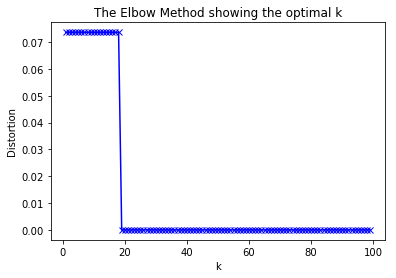

In [98]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('elbow'+method+'.png')

In [330]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, perplexity=20, verbose=2).fit_transform(X_kmeans)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2321 samples in 0.001s...
[t-SNE] Computed neighbors for 2321 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2321
[t-SNE] Computed conditional probabilities for sample 2000 / 2321
[t-SNE] Computed conditional probabilities for sample 2321 / 2321
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.444s
[t-SNE] Iteration 50: error = 65.0737839, gradient norm = 0.0784026 (50 iterations in 3.001s)
[t-SNE] Iteration 100: error = 54.1281204, gradient norm = 0.0433606 (50 iterations in 2.012s)
[t-SNE] Iteration 150: error = 50.8491364, gradient norm = 0.0328969 (50 iterations in 1.833s)
[t-SNE] Iteration 200: error = 49.1697311, gradient norm = 0.0271565 (50 iterations in 1.800s)
[t-SNE] Iteration 250: error = 48.1040573, gradient norm = 0.0239064 (50 iterations in 1.784s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.104057
[t-SNE] Iteration 300: erro

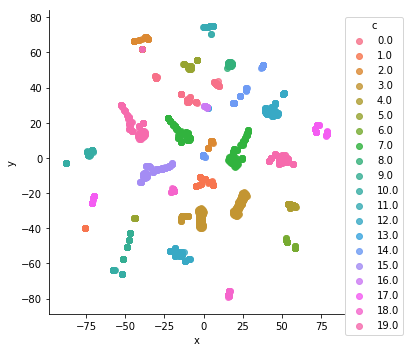

In [331]:
import seaborn as sns
tsne_df = pd.DataFrame(np.append(X_tsne.T,[kmeans_assign],0).T,columns = ['x','y','c'])
sns.lmplot('x', 'y',data = tsne_df, hue='c',size = 5,fit_reg = False)

In [88]:
from sklearn import mixture
n_components_range = range(1, 100)

cts = ['spherical', 'tied', 'diag', 'full']
dict_gmm = dict()

gmm_clusters = {}

for ct in cts:
    bic = []
    lowest_bic = np.infty
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components,
                                  covariance_type=ct)
        
        gmm.fit(X_kmeans)
        bic.append(gmm.bic(X_kmeans))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm  = gmm
    print(lowest_bic)
    print(best_gmm)
    gmm_clusters[ct] = best_gmm.n_components
    gmm_df = pd.DataFrame(np.asarray([temp2.index, best_gmm.predict(X_kmeans)]).T,columns = ['nodes','gmm'+ct])
    temp = pd.merge(temp,gmm_df, how='inner', on='nodes')
    
assign_all = temp.set_index('nodes')
assign_all.to_csv(method+'.csv')

-113267.967772
GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=98, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)
-113733.628196
GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=99, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
-112432.265979
GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=77, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
-106812.246467
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
     

In [89]:
gmm_clusters

{'diag': 77, 'full': 70, 'spherical': 98, 'tied': 99}

In [90]:
assign_all.head()

ml_member  info_member  wt_member  fg_member  lp_member gmmspherical  \
nodes                                                                         
khw            1          276        271        247          0           13   
rra          115            1          4          1          1           12   
gjr          282           27          5        107          2           80   
gtn          220           74        154         66          3           14   
onw            2          277        272        248          4           13   

      gmmtied gmmdiag gmmfull  
nodes                          
khw        19       9      13  
rra        41      12      27  
gjr        75      11      18  
gtn         8       7       1  
onw        19       9      13